In [1]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import random
import csv

In [2]:
def print_solution1(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            location_coord = data['locations'][node_index]
            plan_output += ' ({},{}) -> '.format(location_coord[0], location_coord[1])
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))


In [3]:
def generate_data_model(grid_size, num_locations, num_vehicles,init_depot):
    """Generates the data for the problem with a grid and randomly placed locations."""
    data = {}
    
    # Generate the grid
    grid = [(x, y) for x in range(grid_size) for y in range(grid_size)]
    
    # Randomly select locations from the grid
    locations = init_depot + random.sample(grid, num_locations-1)
    
    # Calculate distances between locations
    distance_matrix = []
    for i in range(num_locations):
        row = []
        for j in range(num_locations):
            if i == j:
                row.append(0)
            else:
                dist = abs(locations[i][0] - locations[j][0]) + abs(locations[i][1] - locations[j][1])
                row.append(dist)
        distance_matrix.append(row)
    
    data['locations'] = locations
    data['distance_matrix'] = distance_matrix
    data['num_vehicles'] = num_vehicles
    data['depot'] = 0  # Assuming the depot is located at index 0
    
    return data

In [4]:
def initialize(data):
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                            data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        5000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    
    return routing,manager

In [5]:
def convert_to_initial_solution(solution, manager, routing, data):
    initial_routes = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            if node_index != 0:
                route.append(data['locations'][node_index])
            index = solution.Value(routing.NextVar(index))
        initial_routes.append(route)
    return initial_routes

In [13]:
# Instantiate the data problem.
grid_size=100
random_locations=50
num_vehicles=5
init_depot = [(50,50)]

data = generate_data_model(grid_size,random_locations,num_vehicles,init_depot)

In [14]:
routing,manager = initialize(data)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 100  # Set a time limit for the solver.

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

In [15]:
# Print solution on console.
if solution:
    print_solution1(data, manager, routing, solution)
else:
    print('No solution found!')
    
convert_solution = convert_to_initial_solution(solution, manager, routing,data)
print(convert_solution)

Objective: 19716
Route for vehicle 0:
 (50,50) ->  (31,48) ->  (17,49) ->  (2,46) ->  (7,37) ->  (42,40) ->  (53,40) ->  (68,38) ->  (77,44) -> Distance of the route: 182m

Route for vehicle 1:
 (50,50) ->  (55,67) ->  (58,71) ->  (57,84) ->  (61,83) ->  (61,84) ->  (62,84) ->  (76,88) ->  (83,85) ->  (85,72) ->  (94,73) ->  (94,63) ->  (85,62) ->  (74,71) ->  (60,54) -> Distance of the route: 188m

Route for vehicle 2:
 (50,50) ->  (49,39) ->  (48,24) ->  (49,20) ->  (54,19) ->  (20,17) ->  (17,3) ->  (23,11) ->  (23,26) ->  (39,44) -> Distance of the route: 172m

Route for vehicle 3:
 (50,50) ->  (21,58) ->  (17,87) ->  (18,89) ->  (13,92) ->  (7,98) ->  (27,97) ->  (35,97) ->  (37,88) ->  (35,84) ->  (48,74) -> Distance of the route: 188m

Route for vehicle 4:
 (50,50) ->  (55,26) ->  (61,27) ->  (99,27) ->  (98,25) ->  (97,7) ->  (95,12) ->  (90,18) ->  (85,48) -> Distance of the route: 186m

Maximum of the route distances: 188m
[[(31, 48), (17, 49), (2, 46), (7, 37), (42, 40), (53

## Visualize routes solutions

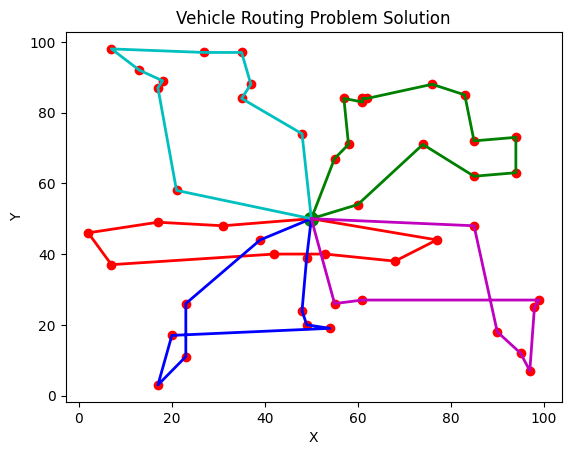

In [16]:
import matplotlib.pyplot as plt

def draw_solution(data, manager, routing, solution):
    """Draws the solution on a graph with color-coded routes for each vehicle."""
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create a list of colors for each vehicle
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    # Plot the nodes
    for node in range(manager.GetNumberOfNodes()):
        if node == data['depot']:
            ax.plot(data['locations'][node][0], data['locations'][node][1], 'go', markersize=10)  # Depot
        else:
            ax.plot(data['locations'][node][0], data['locations'][node][1], 'ro')  # Customers

    # Plot the routes for each vehicle
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route_x = [data['locations'][manager.IndexToNode(index)][0]]
        route_y = [data['locations'][manager.IndexToNode(index)][1]]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route_x.append(data['locations'][manager.IndexToNode(index)][0])
            route_y.append(data['locations'][manager.IndexToNode(index)][1])
        # Get the color for the current vehicle
        color = colors[vehicle_id % len(colors)]
        # Plot the route with the color for the current vehicle
        ax.plot(route_x, route_y, color=color, linewidth=2)

    # Set axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Vehicle Routing Problem Solution')

    # Show the plot
    plt.show()

# Example usage
draw_solution(data, manager, routing, solution)

## Automate the process

In [6]:
nbr_iterations = 350

# Instantiate the data problem.
grid_size=100
random_locations=50
num_vehicles=5
init_depot = [(50,50)]

time_limit = 100

file_path = 'data\\'
file_name='data.csv'

# Create columns in file
with open((file_path+file_name), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)    
    writer.writerow(['x1', 'x2','v'])

    for i in range(nbr_iterations):
        print('Iteration',i)
        
        # Generate data and initialize CP solver
        data = generate_data_model(grid_size,random_locations,num_vehicles,init_depot)
        routing,manager = initialize(data)

        # Setting heuristics
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        search_parameters.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        search_parameters.time_limit.seconds = time_limit  # Set a time limit for the solver.

        # Solve the problem
        solution = routing.SolveWithParameters(search_parameters)
        convert_solution = convert_to_initial_solution(solution, manager, routing,data)
        
        # Save solution
        locations = data['locations']
        for i,vehicle_route in enumerate(convert_solution):
            for coord in vehicle_route:
                writer.writerow([coord[0], coord[1], i])
        writer.writerow([])  # Add a line space


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration